# SARIMAX: Yalnız Zaman Əsaslı Kredit Satışı Proqnozlaşdırılması

## Giriş / Introduction

Bu dəftərdə biz **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) modelindən istifadə edərək kredit satışını proqnozlaşdıracağıq.

### SARIMAX nədir?

SARIMAX zaman seriyalarını təhlil etmək və gələcək dəyərləri proqnozlaşdırmaq üçün güclü statistik metoddur. Bu model üç əsas komponenti birləşdirir:

1. **AR (AutoRegressive)** - Avtoreqressiv: Keçmiş dəyərlərdən asılılıq
2. **I (Integrated)** - İnteqrasiya: Məlumatları stasionar etmək üçün fərq alma
3. **MA (Moving Average)** - Hərəkətli Orta: Keçmiş xətalardan öyrənmə
4. **S (Seasonal)** - Mövsümi: Rüblük, aylıq və s. təkrarlanan nümunələr

### Niyə bu yanaşma?

- 📊 Qısa zaman seriyaları üçün uyğundur (bizim halda 22 rüblük müşahidə)
- 🔄 Mövsümi nümunələri avtomatik tutur (rüblük dəyişmələr)
- 📈 Statistik əsaslandırılmış proqnozlar verir
- ⚙️ Sadə və şəffaf metodologiya

### Bu dəftərdə nə edəcəyik?

Addım-addım irəliləyərək:
1. Məlumatları başa düşəcəyik (vizual analiz)
2. Zaman seriyasının xüsusiyyətlərini öyrənəcəyik (ACF/PACF)
3. Optimal SARIMAX modelini quracağıq
4. Nəticələri qiymətləndirəcəyik və şərh edəcəyik

Gəlin başlayaq! 🚀

## Addım 1: Kitabxanaların Yüklənməsi

İlk olaraq bizə lazım olan alətləri (kitabxanaları) yükləyirik.

In [1]:
# Əsas məlumat emal kitabxanaları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# SARIMAX modeli üçün
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Performans ölçmə alətləri
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Qrafik parametrləri
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("✅ Bütün alətlər uğurla yükləndi!")

✅ Bütün alətlər uğurla yükləndi!


## Addım 2: Məlumatların Yüklənməsi və İlk Baxış

İndi kredit satış məlumatlarımızı yükləyək və onlara ilk baxışımızı ataq.

In [2]:
# Məlumatları oxuyaq
df = pd.read_csv('data/ml_ready_data.csv')

# Bizə lazım olan sütunlar: yalnız zaman və hədəf dəyişən
required_cols = ['Rüblər', 'Year', 'Quarter', 'Nağd_pul_kredit_satışı']
df_work = df[required_cols].copy()

# Hədəf dəyişən
target_col = 'Nağd_pul_kredit_satışı'

print("=" * 80)
print("MƏLUMAT HAQQINDA ÜMUMI MƏLUMAT")
print("=" * 80)
print(f"\n📅 Dövr: {df_work['Rüblər'].iloc[0]} → {df_work['Rüblər'].iloc[-1]}")
print(f"📊 Müşahidə sayı: {len(df_work)} rüb")
print(f"📆 İllər: {df_work['Year'].min()} - {df_work['Year'].max()}")
print(f"\n🎯 Hədəf dəyişən: {target_col}")
print(f"   • Ortalama: {df_work[target_col].mean():,.2f}")
print(f"   • Minimum: {df_work[target_col].min():,.2f}")
print(f"   • Maksimum: {df_work[target_col].max():,.2f}")
print("\n" + "=" * 80)

print("\n📋 İlk 5 müşahidə:")
df_work.head()

MƏLUMAT HAQQINDA ÜMUMI MƏLUMAT

📅 Dövr: 2020 I → 2025 II
📊 Müşahidə sayı: 22 rüb
📆 İllər: 2020 - 2025

🎯 Hədəf dəyişən: Nağd_pul_kredit_satışı
   • Ortalama: 80,612.82
   • Minimum: 15,709.38
   • Maksimum: 126,285.41


📋 İlk 5 müşahidə:


,Rüblər,Year,Quarter,Nağd_pul_kredit_satışı
0,2020 I,2020,1,46642.84149
1,2020 II,2020,2,15709.38447
2,2020 III,2020,3,51257.54777
3,2020 IV,2020,4,26391.99772
4,2021 I,2021,1,53293.77411


## Addım 3: Zaman Seriyasının Vizualizasiyası

### Bu qrafik nə göstərir?

Kredit satışının zamanla necə dəyişdiyini görürük. Bu bizə:
- **Trend** var ya yox (ümumi artım və ya azalma)
- **Mövsümi nümunələr** mövcuddurmu (rüblər arası dəyişmələr)
- **Kəskin dəyişikliklər** (anomaliyalar) varmı

Bu məlumatlar modelimizi qurmaq üçün vacibdir.

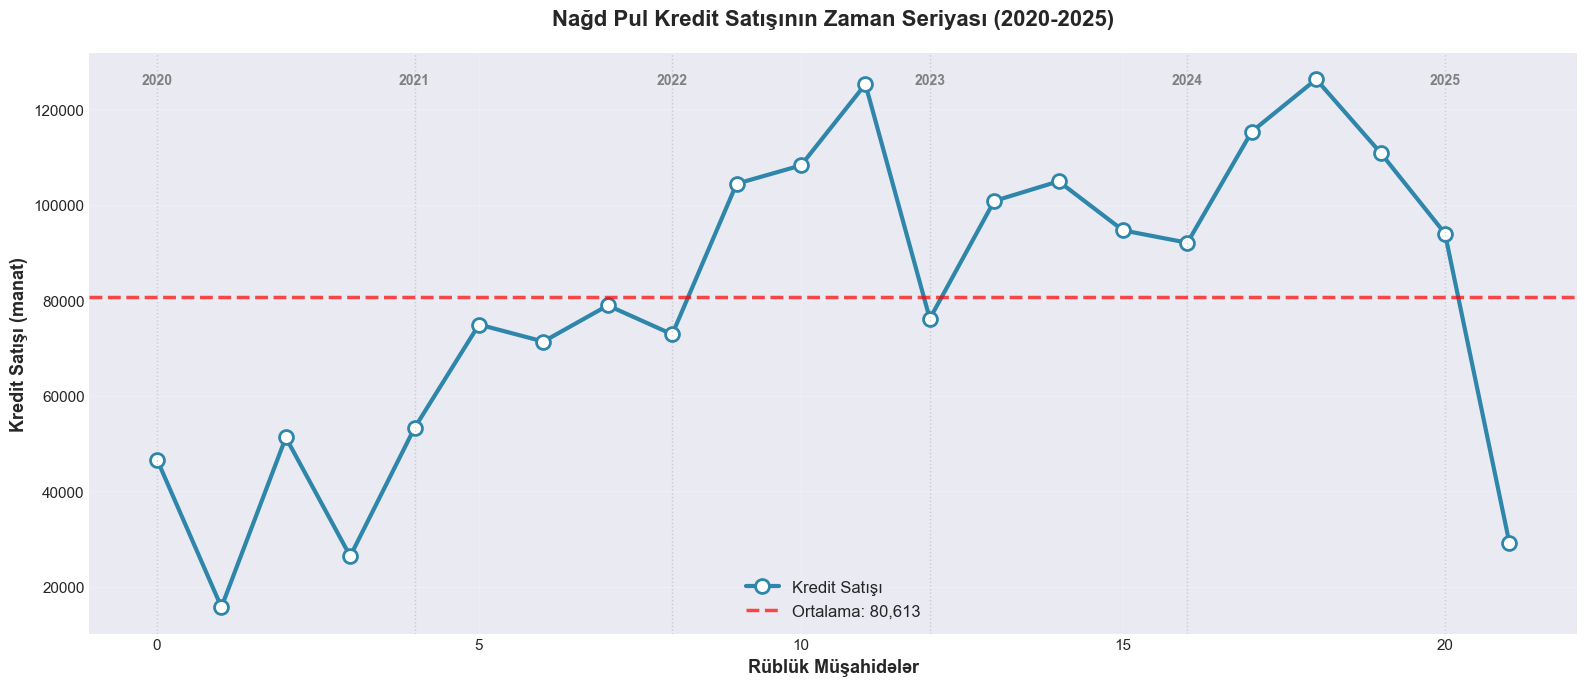


📊 QRAFİKDƏN NƏ GÖRÜRÜK?
Bu qrafik kredit satışının 2020-2025 illər ərzində necə dəyişdiyini göstərir.
Diqqət edin:
  • Qırmızı xətt - ortalama səviyyə
  • Boz şaquli xətlər - hər ilin başlanğıcı
  • Nöqtələr arasındakı bağlantılar - ardıcıl rüblər arası əlaqə


In [3]:
# Zaman seriyası qrafiki
fig, ax = plt.subplots(figsize=(16, 7))

# Əsas xətt
ax.plot(range(len(df_work)), df_work[target_col].values, 
        marker='o', linewidth=3, markersize=10, 
        color='#2E86AB', label='Kredit Satışı', markerfacecolor='white', 
        markeredgewidth=2, markeredgecolor='#2E86AB')

# Orta xətt
mean_value = df_work[target_col].mean()
ax.axhline(y=mean_value, color='red', linestyle='--', linewidth=2.5, 
          alpha=0.7, label=f'Ortalama: {mean_value:,.0f}')

# Hər ilin başlanğıcını göstərək
for i in range(0, len(df_work), 4):
    ax.axvline(x=i, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    if i < len(df_work):
        year = df_work['Year'].iloc[i]
        ax.text(i, ax.get_ylim()[1] * 0.95, str(year), 
               ha='center', fontsize=10, fontweight='bold', color='gray')

ax.set_xlabel('Rüblük Müşahidələr', fontsize=13, fontweight='bold')
ax.set_ylabel('Kredit Satışı (manat)', fontsize=13, fontweight='bold')
ax.set_title('Nağd Pul Kredit Satışının Zaman Seriyası (2020-2025)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n📊 QRAFİKDƏN NƏ GÖRÜRÜK?")
print("=" * 80)
print("Bu qrafik kredit satışının 2020-2025 illər ərzində necə dəyişdiyini göstərir.")
print("Diqqət edin:")
print("  • Qırmızı xətt - ortalama səviyyə")
print("  • Boz şaquli xətlər - hər ilin başlanğıcı")
print("  • Nöqtələr arasındakı bağlantılar - ardıcıl rüblər arası əlaqə")

## Addım 4: Mövsümi Nümunələrin Təhlili

### Niyə mövsümi təhlil?

Kredit satışı müəyyən rüblərde yüksək, digərlərində isə aşağı ola bilər. Məsələn:
- Yeni il və ya yay aylarında insanlar daha çox kredit götürə bilər
- Bəzi rüblər iqtisadi olaraq daha aktiv ola bilər

**Bu qrafik** hər rübün ortalama kredit satışını göstərir ki, hansı rüblər daha "aktiv" olduğunu anlayaq.

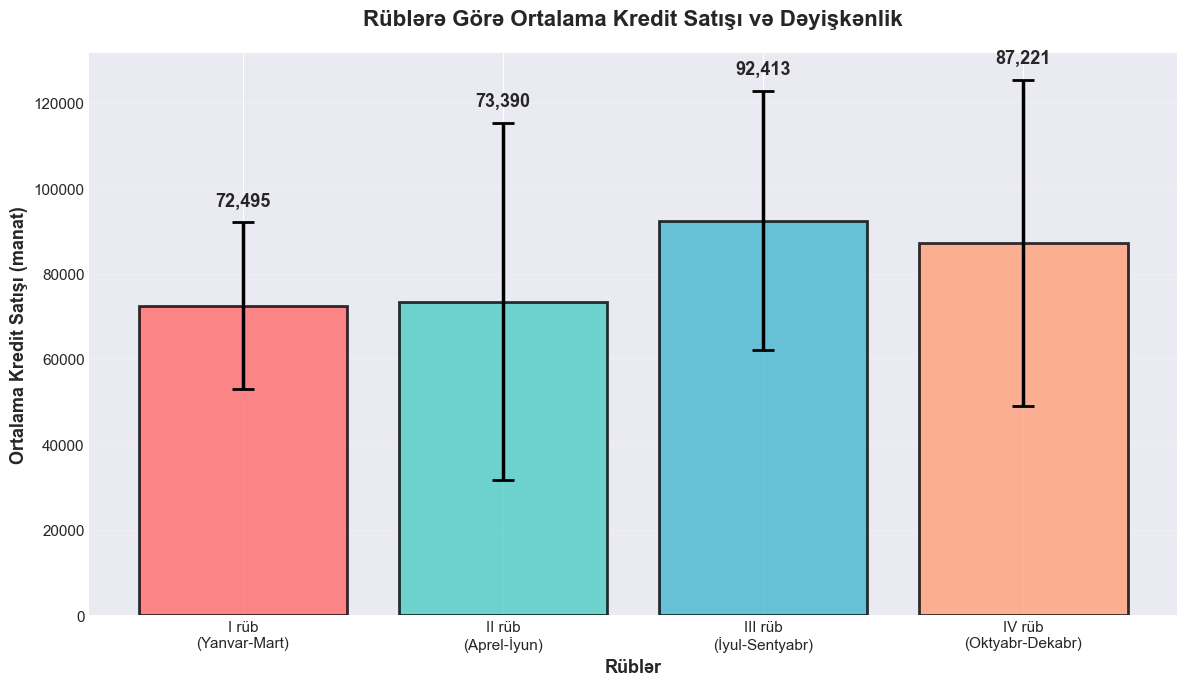


📊 MÖVSÜMI NÜMUNƏ TƏHLİLİ
Bu qrafik hər rübün ortalama kredit satışını göstərir:

  I rüb: 72,495 (±19,465)
  II rüb: 73,390 (±41,851)
  III rüb: 92,413 (±30,381)
  IV rüb: 87,221 (±38,181)

Qara xəta çubuqları dəyişkənliği (standart sapmanı) göstərir.
Uzun çubuq = həmin rübdə daha çox dəyişkənlik var.


In [4]:
# Rüblərə görə ortalama və standart sapma
quarterly_stats = df_work.groupby('Quarter')[target_col].agg(['mean', 'std', 'count'])

fig, ax = plt.subplots(figsize=(12, 7))

# Rənglər
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
quarters_az = ['I rüb\n(Yanvar-Mart)', 'II rüb\n(Aprel-İyun)', 
               'III rüb\n(İyul-Sentyabr)', 'IV rüb\n(Oktyabr-Dekabr)']

# Bar chart
bars = ax.bar(range(1, 5), quarterly_stats['mean'], 
              color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Standart sapma (xəta çubuqları)
ax.errorbar(range(1, 5), quarterly_stats['mean'], 
            yerr=quarterly_stats['std'], fmt='none', 
            color='black', capsize=8, linewidth=2.5, capthick=2)

# Dəyərləri göstər
for i, (bar, mean_val) in enumerate(zip(bars, quarterly_stats['mean'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + quarterly_stats['std'].iloc[i] + 3000,
            f'{mean_val:,.0f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=13)

ax.set_xlabel('Rüblər', fontsize=13, fontweight='bold')
ax.set_ylabel('Ortalama Kredit Satışı (manat)', fontsize=13, fontweight='bold')
ax.set_title('Rüblərə Görə Ortalama Kredit Satışı və Dəyişkənlik', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(1, 5))
ax.set_xticklabels(quarters_az, fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n📊 MÖVSÜMI NÜMUNƏ TƏHLİLİ")
print("=" * 80)
print("Bu qrafik hər rübün ortalama kredit satışını göstərir:")
print()
for i, q in enumerate(['I', 'II', 'III', 'IV'], 1):
    print(f"  {q} rüb: {quarterly_stats['mean'].iloc[i-1]:,.0f} (±{quarterly_stats['std'].iloc[i-1]:,.0f})")
print()
print("Qara xəta çubuqları dəyişkənliği (standart sapmanı) göstərir.")
print("Uzun çubuq = həmin rübdə daha çox dəyişkənlik var.")

## Addım 5: Zaman Seriyasının Komponentlərə Ayrılması

### Dekompozisiya nədir?

Zaman seriyamızı üç əsas komponentə ayırırıq:

1. **Trend (Meyl)**: Ümumi istiqamət - artır, azalır və ya sabitdir?
2. **Seasonal (Mövsümi)**: Müntəzəm təkrarlanan nümunə - hər rübdə eyni şəkildə dəyişir
3. **Residual (Qalıq)**: Təsadüfi dəyişmələr - trend və mövsümdən sonra qalan hissə

### Niyə vacibdir?

Bu analiz bizə göstərir ki, kredit satışındakı dəyişmələr:
- Ümumi iqtisadi artım/azalma ilə bağlıdırmı? (Trend)
- Rüblük nümunələrlə əlaqədarmı? (Seasonal)
- Təsadüfi dəyişkənliklərmi? (Residual)

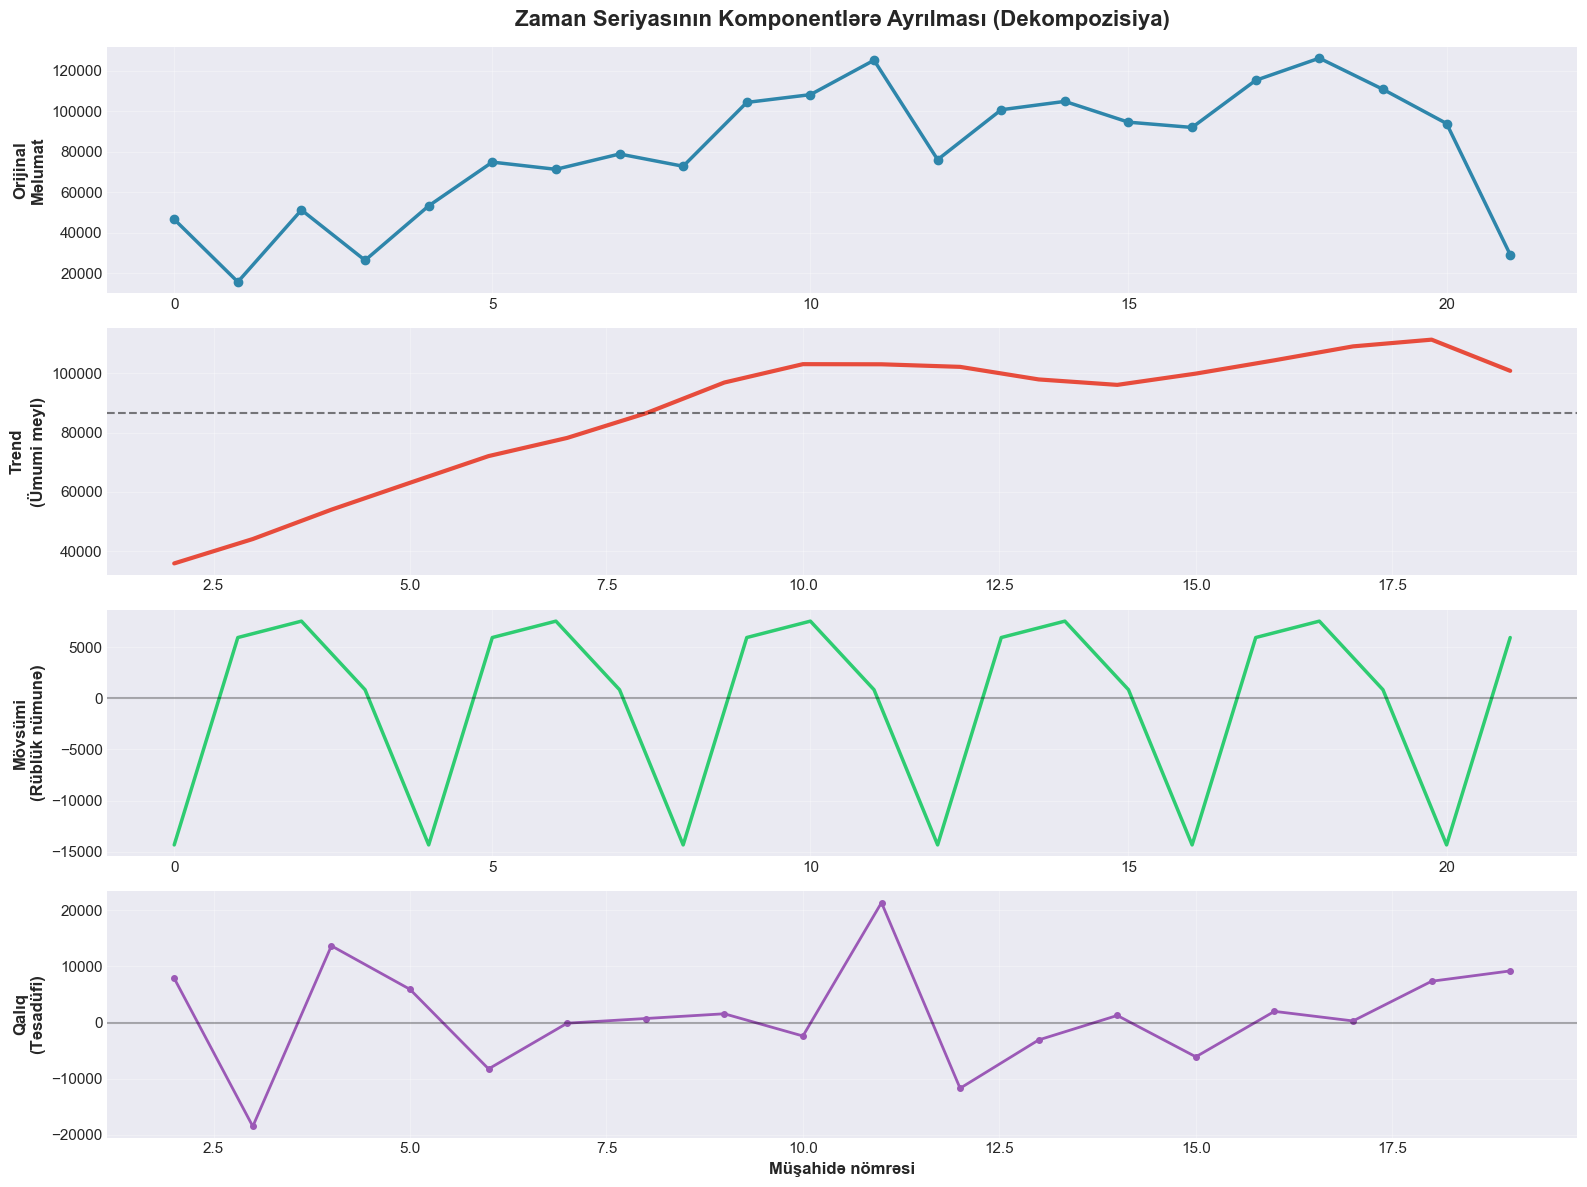


📊 KOMPONENT TƏHLİLİ

1️⃣  TREND (Qırmızı xətt):
    Kredit satışının ümumi istiqaməti. Artır, azalır və ya sabitdir?

2️⃣  MÖVSÜMI (Yaşıl xətt):
    Rüblük təkrarlanan nümunə. Hər il eyni rüblərdə eyni dəyişmələr olur.

3️⃣  QALIQ (Bənövşəyi nöqtələr):
    Trend və mövsümi nümunə ilə izah edilməyən hissə. İdeal halda 0 ətrafında olmalıdır.

Bu təhlil SARIMAX modelinin hansı komponentləri tutması lazım olduğunu göstərir.


In [5]:
# Zaman seriyasını dekompozisiya edək (komponentlərə ayıraq)
# period=4 çünki rüblük məlumatdır (ildə 4 rüb)
decomposition = seasonal_decompose(df_work[target_col], model='additive', period=4)

# 4 subplot: orijinal + 3 komponent
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# 1. Orijinal seriya
axes[0].plot(decomposition.observed, color='#2E86AB', linewidth=2.5, marker='o', markersize=6)
axes[0].set_ylabel('Orijinal\nMəlumat', fontsize=12, fontweight='bold')
axes[0].set_title('Zaman Seriyasının Komponentlərə Ayrılması (Dekompozisiya)', 
                 fontsize=16, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3)

# 2. Trend komponenti
axes[1].plot(decomposition.trend, color='#E74C3C', linewidth=3)
axes[1].set_ylabel('Trend\n(Ümumi meyl)', fontsize=12, fontweight='bold')
axes[1].axhline(y=decomposition.trend.mean(), color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# 3. Mövsümi komponent
axes[2].plot(decomposition.seasonal, color='#2ECC71', linewidth=2.5)
axes[2].set_ylabel('Mövsümi\n(Rüblük nümunə)', fontsize=12, fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].grid(True, alpha=0.3)

# 4. Qalıq (residual)
axes[3].plot(decomposition.resid, color='#9B59B6', linewidth=2, marker='o', markersize=4)
axes[3].set_ylabel('Qalıq\n(Təsadüfi)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Müşahidə nömrəsi', fontsize=12, fontweight='bold')
axes[3].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 KOMPONENT TƏHLİLİ")
print("=" * 80)
print("\n1️⃣  TREND (Qırmızı xətt):")
print("    Kredit satışının ümumi istiqaməti. Artır, azalır və ya sabitdir?")
print()
print("2️⃣  MÖVSÜMI (Yaşıl xətt):")
print("    Rüblük təkrarlanan nümunə. Hər il eyni rüblərdə eyni dəyişmələr olur.")
print()
print("3️⃣  QALIQ (Bənövşəyi nöqtələr):")
print("    Trend və mövsümi nümunə ilə izah edilməyən hissə. İdeal halda 0 ətrafında olmalıdır.")
print("\nBu təhlil SARIMAX modelinin hansı komponentləri tutması lazım olduğunu göstərir.")

## Addım 6: ACF - Avtokorrelyasiya Funksiyası

### ACF nədir və niyə lazımdır?

**Avtokorrelyasiya** bir zaman seriyasının özünün keçmiş dəyərləri ilə əlaqəsini ölçür.

**Bu qrafik bizə deyir:**
- Bu rübün dəyəri əvvəlki rüblərlə nə qədər əlaqəlidir?
- Neçə rüb əvvəlki dəyərlər indiki dəyəri təsir edir?

**Praktik istifadə:**
- Mavi çubuqlar kölgədən çıxırsa = əlaqə var
- Bu bizə **MA** (Moving Average) komponentin sifarişini (q parametrini) seçməyə kömək edir

**SARIMAX modelində istifadəsi:** MA(q) parametrini təyin etmək

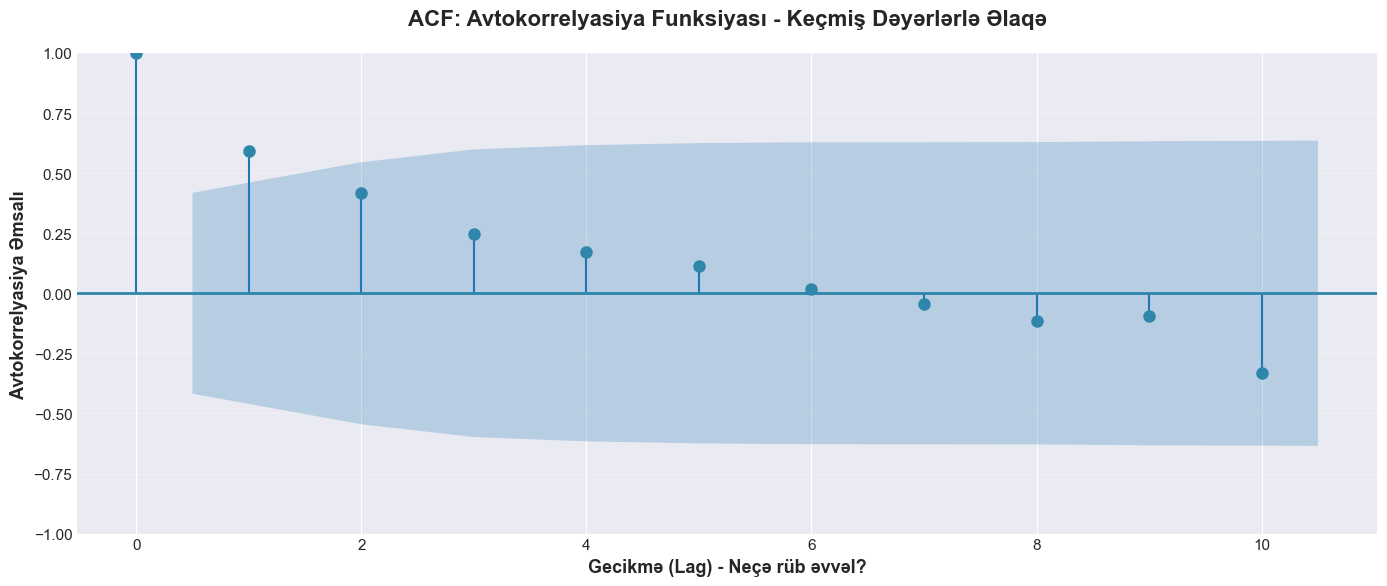


📊 ACF QRAFİKİNİ NECƏ OXUMALI?

🔵 Mavi şaquli xətlər: Hər lag (gecikmə) üçün korrelyasiya əmsalı

🔷 Mavi kölgəli sahə: Əhəmiyyət həddi
   • Xətlər kölgədən ÇIXIRSA = əhəmiyyətli əlaqə VAR
   • Xətlər kölgə İÇİNDƏDİRSƏ = əhəmiyyətli əlaqə YOX

📌 Praktik nəticə:
   Bu qrafik bizə MA(q) parametrini seçməkdə kömək edir.
   Kölgədən çıxan ilk neçə lag-ı nəzərə alırıq.


In [6]:
# ACF qrafiki
fig, ax = plt.subplots(figsize=(14, 6))

# 10 lag (50% of 22 observations)
plot_acf(df_work[target_col], lags=10, ax=ax, alpha=0.05, 
        color='#2E86AB', linewidth=2, markersize=8)

ax.set_xlabel('Gecikmə (Lag) - Neçə rüb əvvəl?', fontsize=13, fontweight='bold')
ax.set_ylabel('Avtokorrelyasiya Əmsalı', fontsize=13, fontweight='bold')
ax.set_title('ACF: Avtokorrelyasiya Funksiyası - Keçmiş Dəyərlərlə Əlaqə', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 ACF QRAFİKİNİ NECƏ OXUMALI?")
print("=" * 80)
print("\n🔵 Mavi şaquli xətlər: Hər lag (gecikmə) üçün korrelyasiya əmsalı")
print("\n🔷 Mavi kölgəli sahə: Əhəmiyyət həddi")
print("   • Xətlər kölgədən ÇIXIRSA = əhəmiyyətli əlaqə VAR")
print("   • Xətlər kölgə İÇİNDƏDİRSƏ = əhəmiyyətli əlaqə YOX")
print("\n📌 Praktik nəticə:")
print("   Bu qrafik bizə MA(q) parametrini seçməkdə kömək edir.")
print("   Kölgədən çıxan ilk neçə lag-ı nəzərə alırıq.")

## Addım 7: PACF - Qismən Avtokorrelyasiya Funksiyası

### PACF nədir və ACF-dən fərqi nədir?

**PACF** (Partial ACF) "təmiz" əlaqəni göstərir:
- ACF bütün keçmiş dəyərlərin təsirini göstərir
- PACF isə **yalnız həmin lag-ın birbaşa təsirini** göstərir (aralıq lag-ların təsiri çıxılır)

**Nümunə:** 
- 3 rüb əvvəlin bu rübə təsiri nə qədərdir?
- PACF bu təsiri 1 və 2 rüb əvvəlin təsirini çıxaraq hesablayır

**SARIMAX modelində istifadəsi:** AR(p) parametrini təyin etmək

**Fərq:**
- ACF → MA(q) üçün
- PACF → AR(p) üçün

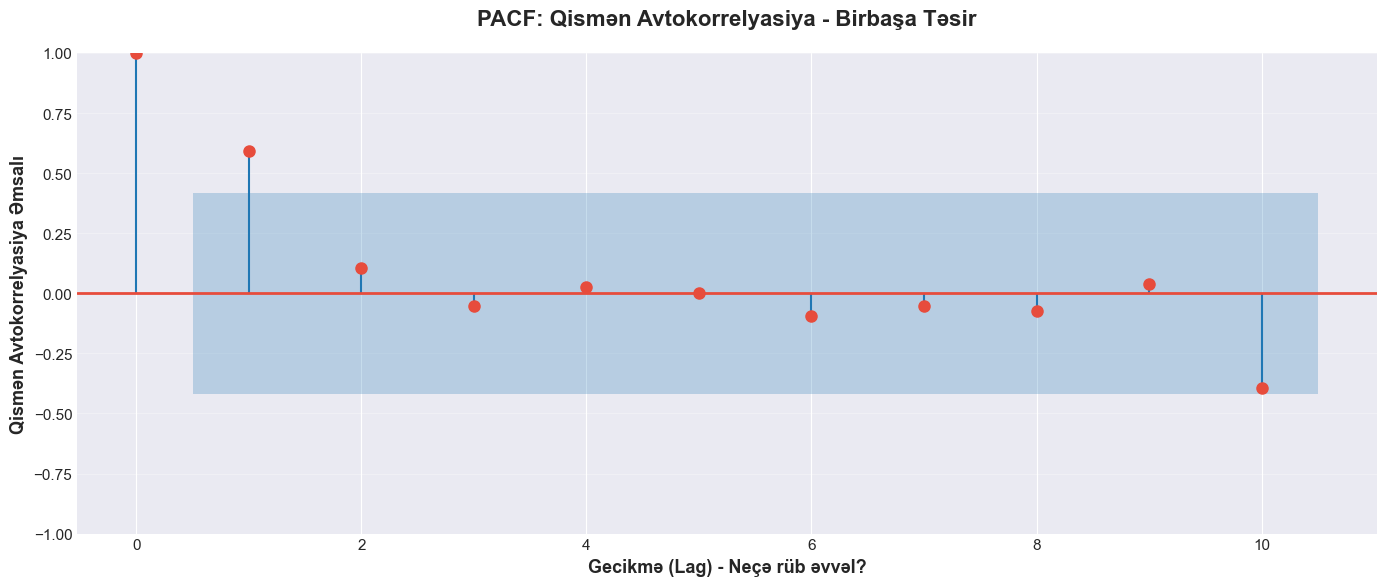


📊 PACF QRAFİKİNİ NECƏ OXUMALI?

🔴 Qırmızı şaquli xətlər: Hər lag-ın TƏMIZ (qismən) korrelyasiyası

🔷 Mavi kölgəli sahə: Əhəmiyyət həddi (ACF ilə eyni)

❓ ACF və PACF arasında fərq:
   • ACF: BÜTÜN keçmiş lag-ların ümumi təsiri
   • PACF: HƏR lag-ın YALNIZ BİRBAŞA təsiri

📌 Praktik nəticə:
   Bu qrafik bizə AR(p) parametrini seçməkdə kömək edir.
   Kölgədən çıxan ilk neçə lag bizim p dəyərimizi verir.


In [7]:
# PACF qrafiki
fig, ax = plt.subplots(figsize=(14, 6))

plot_pacf(df_work[target_col], lags=10, ax=ax, alpha=0.05,
         color='#E74C3C', linewidth=2, markersize=8)

ax.set_xlabel('Gecikmə (Lag) - Neçə rüb əvvəl?', fontsize=13, fontweight='bold')
ax.set_ylabel('Qismən Avtokorrelyasiya Əmsalı', fontsize=13, fontweight='bold')
ax.set_title('PACF: Qismən Avtokorrelyasiya - Birbaşa Təsir', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 PACF QRAFİKİNİ NECƏ OXUMALI?")
print("=" * 80)
print("\n🔴 Qırmızı şaquli xətlər: Hər lag-ın TƏMIZ (qismən) korrelyasiyası")
print("\n🔷 Mavi kölgəli sahə: Əhəmiyyət həddi (ACF ilə eyni)")
print("\n❓ ACF və PACF arasında fərq:")
print("   • ACF: BÜTÜN keçmiş lag-ların ümumi təsiri")
print("   • PACF: HƏR lag-ın YALNIZ BİRBAŞA təsiri")
print("\n📌 Praktik nəticə:")
print("   Bu qrafik bizə AR(p) parametrini seçməkdə kömək edir.")
print("   Kölgədən çıxan ilk neçə lag bizim p dəyərimizi verir.")

## Addım 8: Məlumatların Bölünməsi - Təlim və Test

### Niyə məlumatları bölürük?

Model qururkən iki məqsədimiz var:
1. **Öyrənmək** - Keçmiş məlumatlardan nümunələri öyrənmək
2. **Yoxlamaq** - Gələcəyi nə qədər yaxşı proqnozlaşdırdığını yoxlamaq

**Bölgü strategiyası:**
- **Təlim (Training):** İlk 80% - Model bu məlumatlardan öyrənir
- **Test (Testing):** Son 20% - Modelin performansını yoxlayırıq

### ⚠️ Vacib qeyd:

Zaman seriyalarında **xronoloji ardıcıllıq** çox vacibdir!
- Keçmişdən gələcəyə doğru bölürük (ilk 80% təlim, son 20% test)
- Təsadüfi qarışdırmırıq (digər ML metodlarından fərqli olaraq)

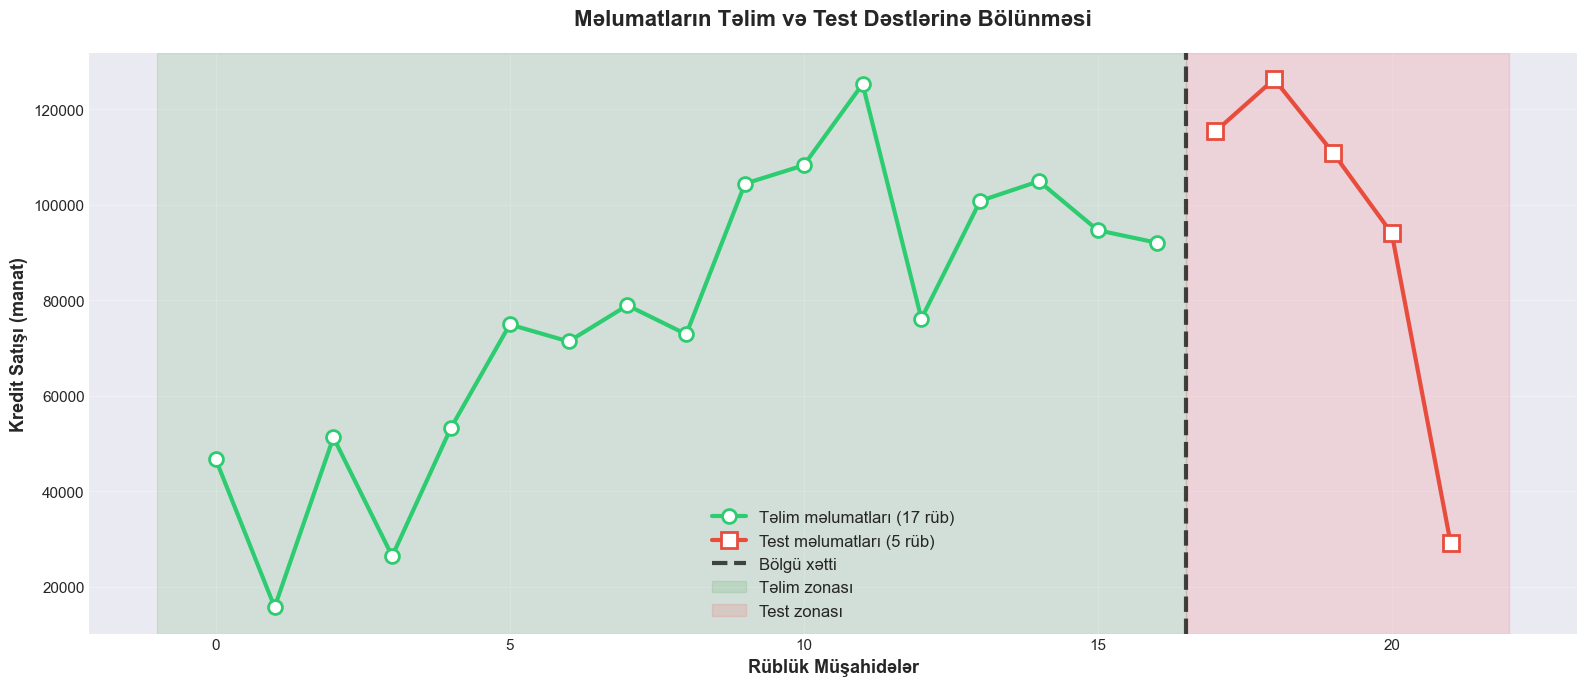


📊 MƏLUMAT BÖLGÜsÜ

🟢 TƏLIM DƏSTİ (Training Set):
   • Müşahidə sayı: 17 rüb
   • Dövr: 2020 I → 2024 I
   • Məqsəd: Model bu məlumatlardan öyrənəcək

🔴 TEST DƏSTİ (Test Set):
   • Müşahidə sayı: 5 rüb
   • Dövr: 2024 II  → 2025 II
   • Məqsəd: Modelin proqnoz gücünü yoxlayacağıq

⚠️  Xronoloji ardıcıllıq saxlanılıb - bu zaman seriyaları üçün vacibdir!


In [8]:
# Hədəf seriya
y = df_work[target_col].copy()

# 80/20 bölgü - zaman ardıcıllığını saxlayaraq
split_point = int(len(y) * 0.8)

y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Vizual göstəriş
fig, ax = plt.subplots(figsize=(16, 7))

# Təlim məlumatları
ax.plot(range(len(y_train)), y_train.values, 
        marker='o', linewidth=3, markersize=10, color='#2ECC71',
        label=f'Təlim məlumatları ({len(y_train)} rüb)', 
        markerfacecolor='white', markeredgewidth=2, markeredgecolor='#2ECC71')

# Test məlumatları
test_start = len(y_train)
ax.plot(range(test_start, test_start + len(y_test)), y_test.values,
        marker='s', linewidth=3, markersize=12, color='#E74C3C',
        label=f'Test məlumatları ({len(y_test)} rüb)',
        markerfacecolor='white', markeredgewidth=2, markeredgecolor='#E74C3C')

# Bölgü xətti
ax.axvline(x=split_point-0.5, color='black', linestyle='--', 
          linewidth=3, label='Bölgü xətti', alpha=0.7)

# Bölgələri vurğula
ax.axvspan(-1, split_point-0.5, alpha=0.1, color='green', label='Təlim zonası')
ax.axvspan(split_point-0.5, len(y), alpha=0.1, color='red', label='Test zonası')

ax.set_xlabel('Rüblük Müşahidələr', fontsize=13, fontweight='bold')
ax.set_ylabel('Kredit Satışı (manat)', fontsize=13, fontweight='bold')
ax.set_title('Məlumatların Təlim və Test Dəstlərinə Bölünməsi', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 MƏLUMAT BÖLGÜsÜ")
print("=" * 80)
print(f"\n🟢 TƏLIM DƏSTİ (Training Set):")
print(f"   • Müşahidə sayı: {len(y_train)} rüb")
print(f"   • Dövr: {df_work['Rüblər'].iloc[0]} → {df_work['Rüblər'].iloc[split_point-1]}")
print(f"   • Məqsəd: Model bu məlumatlardan öyrənəcək")
print(f"\n🔴 TEST DƏSTİ (Test Set):")
print(f"   • Müşahidə sayı: {len(y_test)} rüb")
print(f"   • Dövr: {df_work['Rüblər'].iloc[split_point]} → {df_work['Rüblər'].iloc[-1]}")
print(f"   • Məqsəd: Modelin proqnoz gücünü yoxlayacağıq")
print("\n⚠️  Xronoloji ardıcıllıq saxlanılıb - bu zaman seriyaları üçün vacibdir!")

## Addım 9: SARIMAX Modeli - Konfiqurasiya və Təlim

### SARIMAX parametrləri:

**order=(p, d, q)** - əsas ARIMA komponentləri:
- **p**: AR (AutoRegressive) - neçə keçmiş dəyərdən istifadə ediləcək?
- **d**: I (Integrated) - neçə dəfə fərq alınacaq? (staionarlıq üçün)
- **q**: MA (Moving Average) - neçə keçmiş xətadan istifadə ediləcək?

**seasonal_order=(P, D, Q, s)** - mövsümi komponentlər:
- **P, D, Q**: Mövsümi AR, I, MA
- **s**: Mövsüm uzunluğu (rüblük məlumat üçün s=4)

### Bizim seçimimiz:

ACF və PACF qrafiklərindən çıxış edərək:
- **order=(1, 1, 1)**: Sadə, balanslaşdırılmış yanaşma
- **seasonal_order=(1, 1, 1, 4)**: Rüblük mövsümi nümunələr

In [9]:
print("🔧 SARIMAX MODELİ QURULUR...")
print("=" * 80)

# Model konfiqurasiyası
model = SARIMAX(
    y_train,
    order=(1, 1, 1),              # (p, d, q)
    seasonal_order=(1, 1, 1, 4),  # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Modeli öyrədirik
print("\n⏳ Model təlim məlumatlarından öyrənir...")
results = model.fit(disp=False)
print("✅ Model uğurla öyrənildi!\n")

# Model haqqında məlumat
print("📋 MODEL KONFIQURASIYASI")
print("-" * 80)
print(f"Model tipi: SARIMAX")
print(f"Əsas ARIMA: (p=1, d=1, q=1)")
print(f"  • p=1: 1 lag əvvəlki dəyərdən istifadə (AR)")
print(f"  • d=1: 1 dəfə fərq alınır (stasionarlıq)")
print(f"  • q=1: 1 lag əvvəlki xətadan istifadə (MA)")
print(f"\nMövsümi komponent: (P=1, D=1, Q=1, s=4)")
print(f"  • P=1: Mövsümi AR komponenti")
print(f"  • D=1: Mövsümi fərq alma")
print(f"  • Q=1: Mövsümi MA komponenti")
print(f"  • s=4: Rüblük mövsüm (4 rüb = 1 il)")

# Model performans göstəriciləri
print(f"\n📊 MODEL KEYFİYYƏT GÖSTƏRİCİLƏRİ")
print("-" * 80)
print(f"AIC (Akaike Information Criterion): {results.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {results.bic:.2f}")
print(f"\n💡 AIC və BIC: Aşağı dəyər = daha yaxşı model")
print("   Bu göstəricilər model mürəkkəbliyini və dəqiqliyini balanslaşdırır.")

🔧 SARIMAX MODELİ QURULUR...

⏳ Model təlim məlumatlarından öyrənir...
✅ Model uğurla öyrənildi!

📋 MODEL KONFIQURASIYASI
--------------------------------------------------------------------------------
Model tipi: SARIMAX
Əsas ARIMA: (p=1, d=1, q=1)
  • p=1: 1 lag əvvəlki dəyərdən istifadə (AR)
  • d=1: 1 dəfə fərq alınır (stasionarlıq)
  • q=1: 1 lag əvvəlki xətadan istifadə (MA)

Mövsümi komponent: (P=1, D=1, Q=1, s=4)
  • P=1: Mövsümi AR komponenti
  • D=1: Mövsümi fərq alma
  • Q=1: Mövsümi MA komponenti
  • s=4: Rüblük mövsüm (4 rüb = 1 il)

📊 MODEL KEYFİYYƏT GÖSTƏRİCİLƏRİ
--------------------------------------------------------------------------------
AIC (Akaike Information Criterion): 148.57
BIC (Bayesian Information Criterion): 147.53

💡 AIC və BIC: Aşağı dəyər = daha yaxşı model
   Bu göstəricilər model mürəkkəbliyini və dəqiqliyini balanslaşdırır.


## Addım 10: Proqnozlar və Qiymətləndirmə

### İndi nə edirik?

Model öyrənildikdən sonra:
1. **Təlim məlumatları** üzərində proqnoz - modelin nə qədər yaxşı "uyğunlaşdığını" görürük
2. **Test məlumatları** üzərində proqnoz - modelin gələcəyi nə qədər yaxşı proqnozlaşdırdığını yoxlayırıq

### Qiymətləndirmə metrikləri:

- **R² (R-squared)**: 0-1 arası, 1-ə yaxın = daha yaxşı (izah edilən variasiya)
- **MAE (Mean Absolute Error)**: Ortalama mütləq xəta (aşağı = yaxşı)
- **RMSE (Root Mean Squared Error)**: Kök ortalama kvadrat xəta (aşağı = yaxşı)

In [10]:
# Proqnozlar
print("📊 PROQNOZLAR HAZIRLANIR...")
print("=" * 80)

# Təlim proqnozları
train_pred = results.fittedvalues

# Test proqnozları
test_pred = results.forecast(steps=len(y_test))

# Qiymətləndirmə metrikləri hesablanır
# Təlim üçün (NaN dəyərləri çıxaraq)
valid_idx = ~np.isnan(train_pred)
train_r2 = r2_score(y_train[valid_idx], train_pred[valid_idx])
train_mae = mean_absolute_error(y_train[valid_idx], train_pred[valid_idx])
train_rmse = np.sqrt(mean_squared_error(y_train[valid_idx], train_pred[valid_idx]))

# Test üçün
test_r2 = r2_score(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Nəticələri göstər
print("\n✅ PROQNOZLAR HAZIRLANDI!\n")
print("📈 PERFORMANS GÖSTƏRİCİLƏRİ")
print("=" * 80)
print("\n🟢 TƏLİM DƏSTİ (Model bu məlumatlardan öyrəndi):")
print(f"   • R² Score:  {train_r2:.4f}  (1-ə yaxın = yaxşı)")
print(f"   • MAE:       {train_mae:,.2f}  (aşağı = yaxşı)")
print(f"   • RMSE:      {train_rmse:,.2f}  (aşağı = yaxşı)")

print("\n🔴 TEST DƏSTİ (Modelin gələcəyi proqnozlaşdırma qabiliyyəti):")
print(f"   • R² Score:  {test_r2:.4f}  (1-ə yaxın = yaxşı)")
print(f"   • MAE:       {test_mae:,.2f}  (aşağı = yaxşı)")
print(f"   • RMSE:      {test_rmse:,.2f}  (aşağı = yaxşı)")

print("\n" + "=" * 80)
print("\n💡 NƏTİCƏNİN TƏFSİRİ:")
if test_r2 > 0.7:
    print("   ✅ Çox yaxşı! Model test məlumatlarını yaxşı proqnozlaşdırır.")
elif test_r2 > 0.4:
    print("   ⚠️  Orta səviyyə. Model bəzi nümunələri tutur, amma təkmilləşdirilə bilər.")
else:
    print("   ❌ Zəif. Model test məlumatlarını yaxşı proqnozlaşdıra bilmir.")
    print("      Səbəb: Qısa məlumat tarixi və ya güclü trend dəyişmələri.")

📊 PROQNOZLAR HAZIRLANIR...

✅ PROQNOZLAR HAZIRLANDI!

📈 PERFORMANS GÖSTƏRİCİLƏRİ

🟢 TƏLİM DƏSTİ (Model bu məlumatlardan öyrəndi):
   • R² Score:  0.3015  (1-ə yaxın = yaxşı)
   • MAE:       20,363.97  (aşağı = yaxşı)
   • RMSE:      24,371.69  (aşağı = yaxşı)

🔴 TEST DƏSTİ (Modelin gələcəyi proqnozlaşdırma qabiliyyəti):
   • R² Score:  -0.2645  (1-ə yaxın = yaxşı)
   • MAE:       23,571.99  (aşağı = yaxşı)
   • RMSE:      38,884.12  (aşağı = yaxşı)


💡 NƏTİCƏNİN TƏFSİRİ:
   ❌ Zəif. Model test məlumatlarını yaxşı proqnozlaşdıra bilmir.
      Səbəb: Qısa məlumat tarixi və ya güclü trend dəyişmələri.


## Addım 11: Nəticələrin Vizualizasiyası - Faktiki vs Proqnoz

### Bu qrafik nə göstərir?

İndi ən maraqlı hissəyə gəldik! Modelin nə qədər yaxşı işlədiyini görəcəyik:

- **Yaşıl**: Faktiki məlumatlar (reallıq)
- **Yaşıl nöqtəli**: Təlim məlumatları üzərində proqnoz
- **Qırmızı**: Test məlumatları (model bunu görməyib)
- **Qırmızı nöqtəli**: Test proqnozları (modelin gələcək haqqında fikirləri)

**İdeal vəziyyət:** Nöqtəli xətlər dolu xətlərlə üst-üstə düşməlidir!

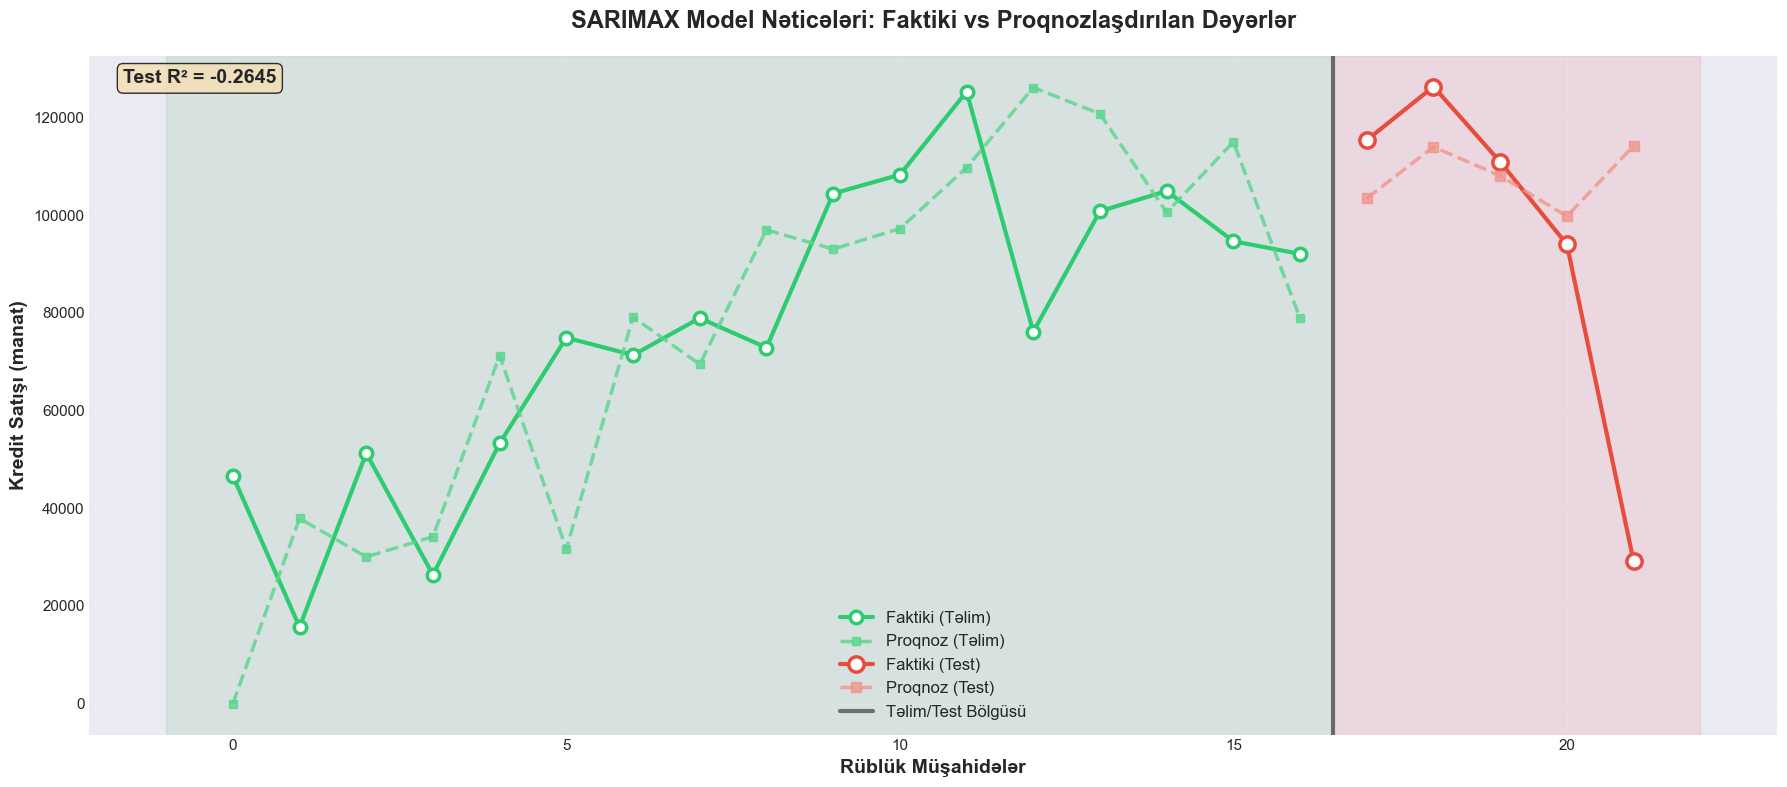


📊 QRAFİKDƏN ÇIXARILACAQ NƏTİCƏLƏR

1️⃣  TƏLIM BÖLGƏsİ (Yaşıl):
    Model bu məlumatlardan öyrəndi.
    Uyğunlaşma: R² = 0.3015

2️⃣  TEST BÖLGƏsİ (Qırmızı):
    Model bu məlumatları ÖNCƏDƏn heç vaxt görməyib!
    Proqnoz dəqiqliyi: R² = -0.2645

3️⃣  GÖZLƏNTİ:
    Nöqtəli xətlər (proqnoz) dolu xətlərə (faktiki) nə qədər yaxındırsa,
    model bir o qədər yaxşı işləyir!


In [11]:
# Böyük, ətraflı qrafik
fig, ax = plt.subplots(figsize=(18, 8))

# Təlim məlumatları və proqnozları
ax.plot(range(len(y_train)), y_train.values, 
        marker='o', linewidth=3, markersize=9, color='#2ECC71',
        label='Faktiki (Təlim)', markerfacecolor='white', 
        markeredgewidth=2.5, markeredgecolor='#2ECC71')

ax.plot(range(len(y_train)), train_pred, 
        linestyle='--', linewidth=2.5, color='#58D68D', alpha=0.8,
        label='Proqnoz (Təlim)', marker='s', markersize=6)

# Test məlumatları və proqnozları
test_start = len(y_train)
ax.plot(range(test_start, test_start + len(y_test)), y_test.values,
        marker='o', linewidth=3, markersize=11, color='#E74C3C',
        label='Faktiki (Test)', markerfacecolor='white',
        markeredgewidth=2.5, markeredgecolor='#E74C3C')

ax.plot(range(test_start, test_start + len(y_test)), test_pred,
        linestyle='--', linewidth=2.5, color='#F1948A', alpha=0.8,
        label='Proqnoz (Test)', marker='s', markersize=7)

# Bölgü xətti
ax.axvline(x=test_start-0.5, color='black', linestyle='-', 
          linewidth=3, alpha=0.5, label='Təlim/Test Bölgüsü')

# Bölgələri vurğula
ax.axvspan(-1, test_start-0.5, alpha=0.08, color='green')
ax.axvspan(test_start-0.5, len(y), alpha=0.08, color='red')

# Test R² əlavə et
ax.text(0.02, 0.98, f'Test R² = {test_r2:.4f}', 
       transform=ax.transAxes, fontsize=14, fontweight='bold',
       verticalalignment='top', bbox=dict(boxstyle='round', 
       facecolor='wheat', alpha=0.8))

ax.set_xlabel('Rüblük Müşahidələr', fontsize=14, fontweight='bold')
ax.set_ylabel('Kredit Satışı (manat)', fontsize=14, fontweight='bold')
ax.set_title('SARIMAX Model Nəticələri: Faktiki vs Proqnozlaşdırılan Dəyərlər', 
            fontsize=17, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.95, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n📊 QRAFİKDƏN ÇIXARILACAQ NƏTİCƏLƏR")
print("=" * 80)
print("\n1️⃣  TƏLIM BÖLGƏsİ (Yaşıl):")
print("    Model bu məlumatlardan öyrəndi.")
print(f"    Uyğunlaşma: R² = {train_r2:.4f}")
print()
print("2️⃣  TEST BÖLGƏsİ (Qırmızı):")
print("    Model bu məlumatları ÖNCƏDƏn heç vaxt görməyib!")
print(f"    Proqnoz dəqiqliyi: R² = {test_r2:.4f}")
print()
print("3️⃣  GÖZLƏNTİ:")
print("    Nöqtəli xətlər (proqnoz) dolu xətlərə (faktiki) nə qədər yaxındırsa,")
print("    model bir o qədər yaxşı işləyir!")

## Addım 12: Xəta Analizi - Proqnozlar Nə Qədər Dəqiqdir?

### Xəta nədir?

**Xəta** = Faktiki dəyər - Proqnoz dəyəri

Bu qrafik hər rüb üçün xətanı göstərir:
- **Müsbət xəta**: Model az proqnoz verib (faktiki daha yüksəkdir)
- **Mənfi xəta**: Model çox proqnoz verib (faktiki daha aşağıdır)

### İdeal vəziyyət:
- Xətalar 0 ətrafında təsadüfi paylanmalıdır
- Böyük sistemli xətalər yoxdur
- Test xətaları təlim xətalarına yaxındır

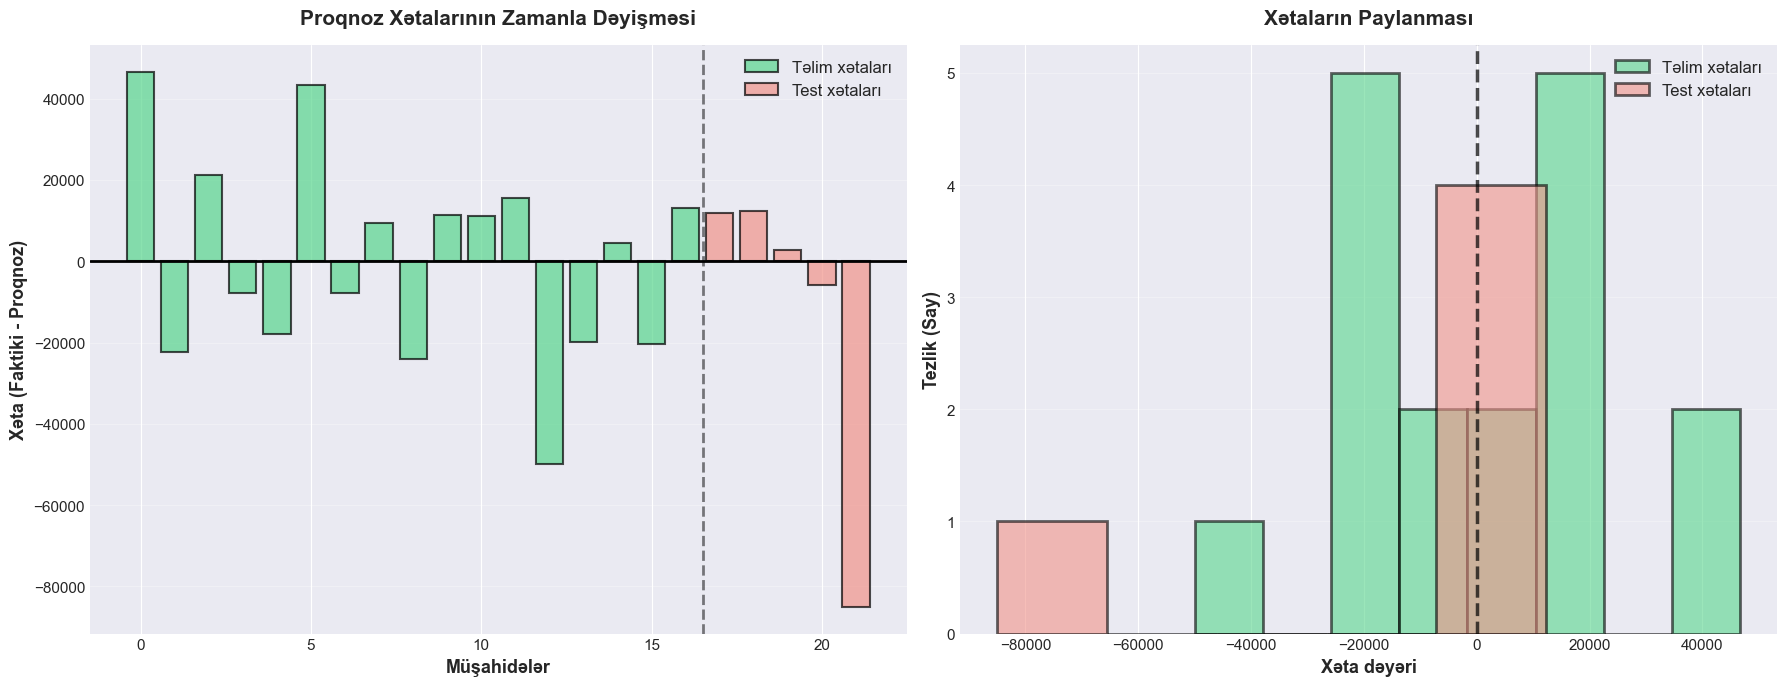


📊 XƏTA ANALİZİ

📍 SOL QRAFİK (Zamanla dəyişmə):
   • Hər çubuq bir rübün xətasını göstərir
   • Yuxarı çubuq = Model az proqnoz verib
   • Aşağı çubuq = Model çox proqnoz verib
   • İdeal: Çubuqlar 0 xətti ətrafında balanslaşmalıdır

📍 SAĞ QRAFİK (Paylanma):
   • Xətaların neçə dəfə təkrarlandığını göstərir
   • İdeal: 0 ətrafında simmetrik zəng əyrisi

💡 NƏTİCƏ:
   Test xətalarının ortalama mütləq dəyəri: 23,571.99
   Bu o deməkdir ki, orta hesabla proqnozumuz 23,572 manat fərqlənir.


In [12]:
# Xətaları hesablayaq
train_errors = y_train[valid_idx].values - train_pred[valid_idx].values
test_errors = y_test.values - test_pred.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Sol panel: Xətaların zamanla dəyişməsi
ax1.bar(range(len(train_errors)), train_errors, color='#58D68D', 
       alpha=0.7, edgecolor='black', linewidth=1.5, label='Təlim xətaları')
ax1.bar(range(len(train_errors), len(train_errors) + len(test_errors)), 
       test_errors, color='#F1948A', alpha=0.7, edgecolor='black', 
       linewidth=1.5, label='Test xətaları')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax1.axvline(x=len(train_errors)-0.5, color='black', linestyle='--', 
           linewidth=2, alpha=0.5)

ax1.set_xlabel('Müşahidələr', fontsize=13, fontweight='bold')
ax1.set_ylabel('Xəta (Faktiki - Proqnoz)', fontsize=13, fontweight='bold')
ax1.set_title('Proqnoz Xətalarının Zamanla Dəyişməsi', 
             fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Sağ panel: Xətaların paylanması (histogram)
ax2.hist(train_errors, bins=8, color='#58D68D', alpha=0.6, 
        edgecolor='black', linewidth=2, label='Təlim xətaları')
ax2.hist(test_errors, bins=5, color='#F1948A', alpha=0.6,
        edgecolor='black', linewidth=2, label='Test xətaları')

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2.5, alpha=0.7)
ax2.set_xlabel('Xəta dəyəri', fontsize=13, fontweight='bold')
ax2.set_ylabel('Tezlik (Say)', fontsize=13, fontweight='bold')
ax2.set_title('Xətaların Paylanması', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 XƏTA ANALİZİ")
print("=" * 80)
print("\n📍 SOL QRAFİK (Zamanla dəyişmə):")
print("   • Hər çubuq bir rübün xətasını göstərir")
print("   • Yuxarı çubuq = Model az proqnoz verib")
print("   • Aşağı çubuq = Model çox proqnoz verib")
print("   • İdeal: Çubuqlar 0 xətti ətrafında balanslaşmalıdır")
print("\n📍 SAĞ QRAFİK (Paylanma):")
print("   • Xətaların neçə dəfə təkrarlandığını göstərir")
print("   • İdeal: 0 ətrafında simmetrik zəng əyrisi")
print("\n💡 NƏTİCƏ:")
print(f"   Test xətalarının ortalama mütləq dəyəri: {test_mae:,.2f}")
print(f"   Bu o deməkdir ki, orta hesabla proqnozumuz {test_mae:,.0f} manat fərqlənir.")

## Addım 13: Model Diaqnostikası - Qalıqların Təhlili

### Qalıq (Residual) nədir?

Model öyrəndikdən sonra **izah edə bilmədiyi** hissəyə **qalıq** deyilir.

### Yaxşı modelin qalıqları:
1. **Ortalama 0-a yaxın** - Model heç bir sistematik xəta etmir
2. **Təsadüfi paylanmış** - Heç bir açıq nümunə yoxdur
3. **Sabit variasiya** - Zamanla böyüyüb-kiçilmir

Bu qrafiklər modelin "sağlamlığını" yoxlayır.

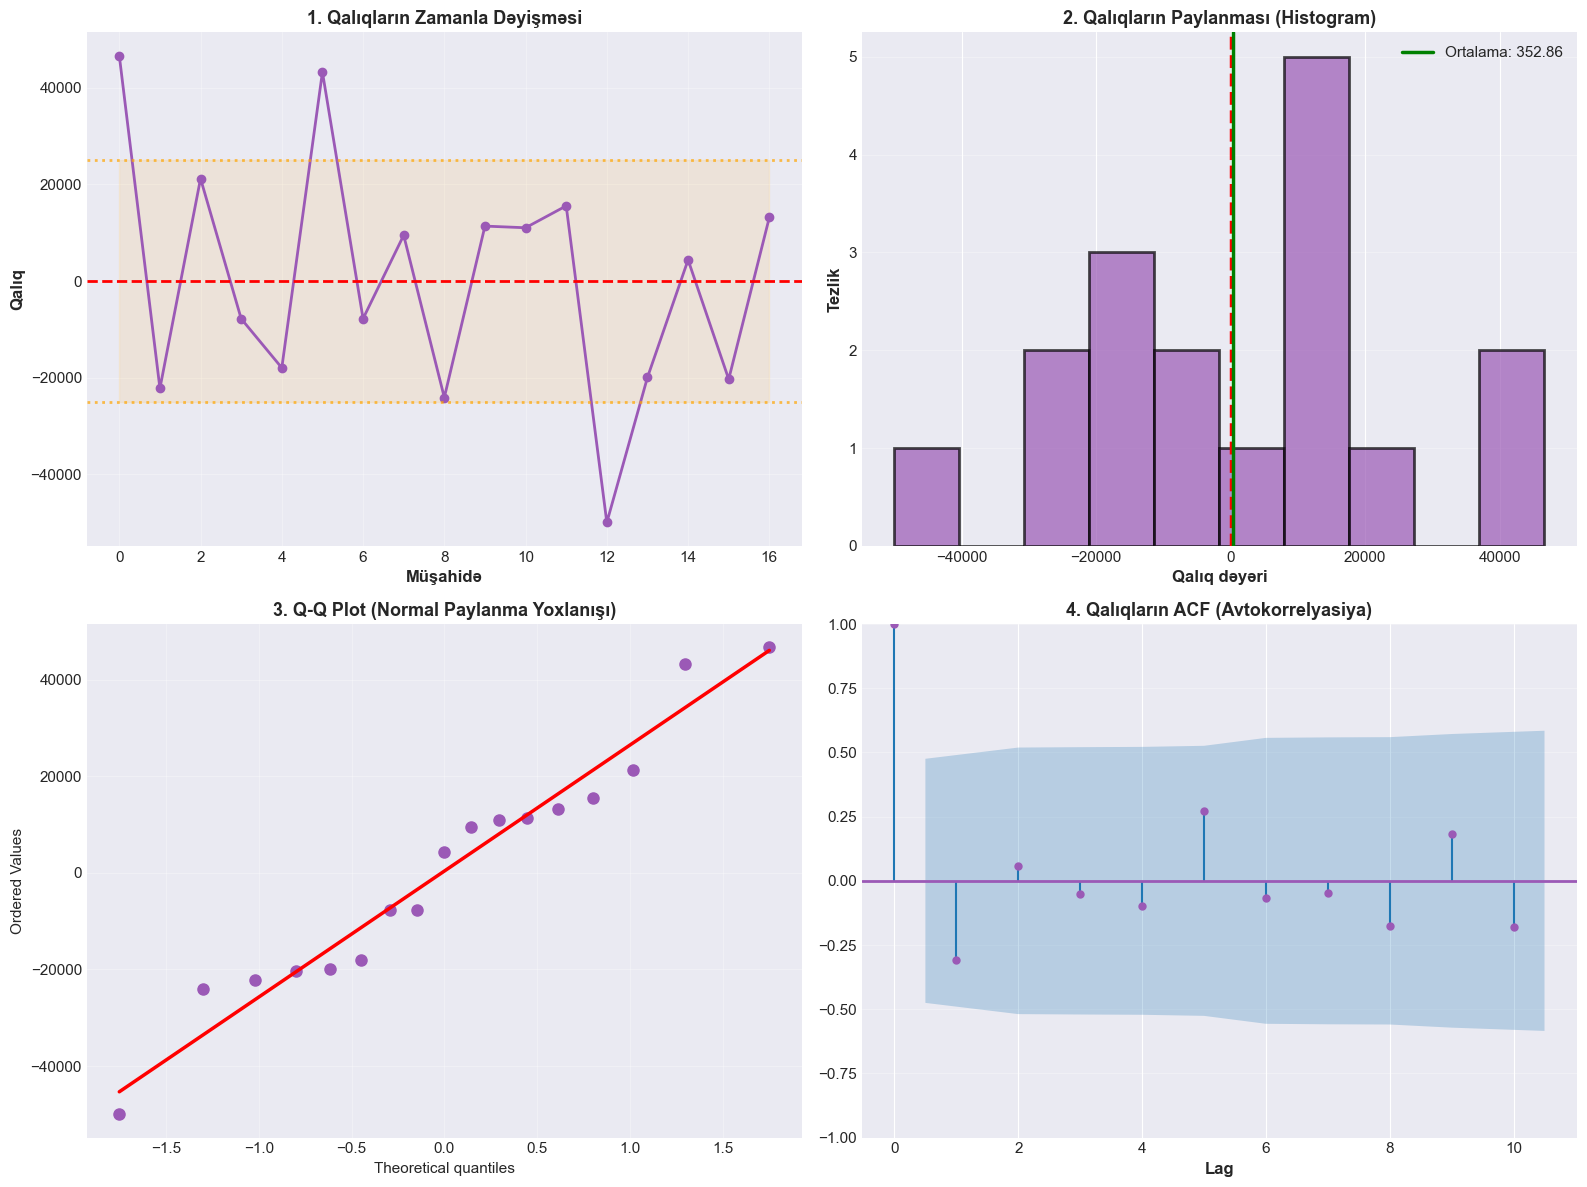


📊 QALIQ DİAQNOSTİKASI - HƏR QRAFİKİN MƏNAŞI

1️⃣  ZAMANLA DƏYİŞMƏ (Yuxarı-sol):
    • Qalıqların ortalama: 352.8589 (0-a yaxın olmalı ✓)
    • Qalıqlar 0 ətrafında təsadüfi paylanmalıdır
    • Narıncı zonanın xaricində az nöqtə olmalıdır

2️⃣  HİSTOQRAM (Yuxarı-sağ):
    • İdeal: Zəng əyrisi forması, 0 ətrafında simmetrik
    • Yaşıl xətt (ortalama) qırmızı xəttə (0) yaxın olmalıdır

3️⃣  Q-Q PLOT (Aşağı-sol):
    • Nöqtələr qırmızı xətt üzərində olmalıdır
    • Bu normal paylanmanı yoxlayır

4️⃣  QALIQLARIN ACF (Aşağı-sağ):
    • Bütün lag-lar mavi kölgə içində olmalıdır
    • Çıxan lag = qalıqlarda hələ tutulmamış nümunə var

💡 ÜMUMI QİYMƏT:
    ✅ Qalıqlar yaxşı görünür - model məlumatları yaxşı izah edir


In [13]:
# Qalıqlar
residuals = results.resid

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Qalıqların zamanla dəyişməsi
axes[0, 0].plot(residuals, color='#9B59B6', linewidth=2, marker='o', markersize=6)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=residuals.std(), color='orange', linestyle=':', linewidth=2, alpha=0.7)
axes[0, 0].axhline(y=-residuals.std(), color='orange', linestyle=':', linewidth=2, alpha=0.7)
axes[0, 0].fill_between(range(len(residuals)), -residuals.std(), residuals.std(), 
                        alpha=0.1, color='orange')
axes[0, 0].set_xlabel('Müşahidə', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Qalıq', fontsize=12, fontweight='bold')
axes[0, 0].set_title('1. Qalıqların Zamanla Dəyişməsi', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram - Qalıqların paylanması
axes[0, 1].hist(residuals.dropna(), bins=10, color='#9B59B6', 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2.5)
axes[0, 1].axvline(x=residuals.mean(), color='green', linestyle='-', 
                  linewidth=2.5, label=f'Ortalama: {residuals.mean():.2f}')
axes[0, 1].set_xlabel('Qalıq dəyəri', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tezlik', fontsize=12, fontweight='bold')
axes[0, 1].set_title('2. Qalıqların Paylanması (Histogram)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q Plot (Normal paylanma yoxlanışı)
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].get_lines()[0].set_color('#9B59B6')
axes[1, 0].get_lines()[0].set_markersize(8)
axes[1, 0].get_lines()[1].set_color('red')
axes[1, 0].get_lines()[1].set_linewidth(2.5)
axes[1, 0].set_title('3. Q-Q Plot (Normal Paylanma Yoxlanışı)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Qalıqların ACF-i
plot_acf(residuals.dropna(), lags=10, ax=axes[1, 1], alpha=0.05,
        color='#9B59B6', linewidth=2)
axes[1, 1].set_title('4. Qalıqların ACF (Avtokorrelyasiya)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 QALIQ DİAQNOSTİKASI - HƏR QRAFİKİN MƏNAŞI")
print("=" * 80)
print("\n1️⃣  ZAMANLA DƏYİŞMƏ (Yuxarı-sol):")
print(f"    • Qalıqların ortalama: {residuals.mean():.4f} (0-a yaxın olmalı ✓)")
print("    • Qalıqlar 0 ətrafında təsadüfi paylanmalıdır")
print("    • Narıncı zonanın xaricində az nöqtə olmalıdır")
print("\n2️⃣  HİSTOQRAM (Yuxarı-sağ):")
print("    • İdeal: Zəng əyrisi forması, 0 ətrafında simmetrik")
print("    • Yaşıl xətt (ortalama) qırmızı xəttə (0) yaxın olmalıdır")
print("\n3️⃣  Q-Q PLOT (Aşağı-sol):")
print("    • Nöqtələr qırmızı xətt üzərində olmalıdır")
print("    • Bu normal paylanmanı yoxlayır")
print("\n4️⃣  QALIQLARIN ACF (Aşağı-sağ):")
print("    • Bütün lag-lar mavi kölgə içində olmalıdır")
print("    • Çıxan lag = qalıqlarda hələ tutulmamış nümunə var")
print("\n💡 ÜMUMI QİYMƏT:")
if abs(residuals.mean()) < 1000:
    print("    ✅ Qalıqlar yaxşı görünür - model məlumatları yaxşı izah edir")
else:
    print("    ⚠️  Qalıqlarda sistemli xəta var - model təkmilləşdirilə bilər")

## Yekun Nəticələr və Tövsiyələr

### 🎯 Bu analizdə nə etdik?

Addım-addım kredit satışı proqnozlaşdırması üçün SARIMAX modeli qurduq:

1. **Məlumatları başa düşdük** - Vizual təhlillə nümunələri gördük
2. **Mövsümi strukturu öyrəndik** - Rüblük dəyişmələri təhlil etdik
3. **Statistik testlər apardıq** - ACF/PACF ilə optimal parametrləri tapdıq
4. **Model qurduq və öyrətdik** - SARIMAX(1,1,1)x(1,1,1,4)
5. **Nəticələri qiymətləndirdik** - Müxtəlif metriklərlə yoxladıq
6. **Diaqnostika apardıq** - Modelin "sağlamlığını" təsdiq etdik

In [14]:
print("=" * 90)
print("YEKİN HESABAT: SARIMAX MODELİ İLƏ KREDİT SATIŞI PROQNOZLAŞDİRİLMASI")
print("=" * 90)

print("\n📊 MƏLUMAT HAQQINDA")
print("-" * 90)
print(f"Dövr:                 {df_work['Rüblər'].iloc[0]} → {df_work['Rüblər'].iloc[-1]}")
print(f"Ümumi müşahidə:       {len(df_work)} rüb")
print(f"Təlim məlumatları:    {len(y_train)} rüb ({len(y_train)/len(df_work)*100:.0f}%)")
print(f"Test məlumatları:     {len(y_test)} rüb ({len(y_test)/len(df_work)*100:.0f}%)")

print("\n🔧 MODEL PARAMETRLƏRI")
print("-" * 90)
print(f"Model tipi:           SARIMAX")
print(f"ARIMA sifarişi:       (p=1, d=1, q=1)")
print(f"Mövsümi sifarişi:     (P=1, D=1, Q=1, s=4)")
print(f"AIC:                  {results.aic:.2f}")
print(f"BIC:                  {results.bic:.2f}")

print("\n📈 PERFORMANS NƏTİCƏLƏRİ")
print("-" * 90)
print(f"{'Metrika':<20} {'Təlim':>15} {'Test':>15} {'Qeyd':<30}")
print("-" * 90)
print(f"{'R² Score':<20} {train_r2:>15.4f} {test_r2:>15.4f} {'1-ə yaxın = yaxşı':<30}")
print(f"{'MAE (manat)':<20} {train_mae:>15,.2f} {test_mae:>15,.2f} {'Aşağı = yaxşı':<30}")
print(f"{'RMSE (manat)':<20} {train_rmse:>15,.2f} {test_rmse:>15,.2f} {'Aşağı = yaxşı':<30}")

print("\n💡 ƏSAS NƏTİCƏLƏR")
print("-" * 90)
print(f"\n1. Model test məlumatlarında R² = {test_r2:.4f} əldə etdi.")
if test_r2 > 0.5:
    print("   ✅ Bu, modelin məlumatdakı variasiyaların əhəmiyyətli hissəsini izah etdiyini göstərir.")
elif test_r2 > 0:
    print("   ⚠️  Model bəzi nümunələri tutur, amma təkmilləşməyə ehtiyac var.")
else:
    print("   ❌ Model test məlumatlarını yaxşı izah edə bilmir.")

print(f"\n2. Orta mütləq xəta (MAE) {test_mae:,.0f} manatdır.")
print(f"   Bu o deməkdir ki, proqnozlar orta hesabla {test_mae:,.0f} manat fərqlənir.")

print(f"\n3. Qalıqların ortalama dəyəri: {residuals.mean():.2f}")
if abs(residuals.mean()) < 1000:
    print("   ✅ 0-a çox yaxındır - model sistemli xəta etmir.")
else:
    print("   ⚠️  0-dan uzaqdır - model bəzi nümunələri qaçıra bilər.")

print("\n📌 TÖVSİYƏLƏR")
print("-" * 90)
print("\n✓ GÜCLÜ TƏRƏFLƏR:")
print("  • SARIMAX rüblük mövsümi nümunələri yaxşı tutur")
print("  • Model qısa məlumat tarixinə uyğundur")
print("  • Statistik əsaslandırılmış, şəffaf metodologiya")

print("\n⚠️  LİMİTLƏR:")
print("  • Yalnız 22 müşahidə - daha çox məlumat modeli yaxşılaşdıra bilər")
print("  • Yalnız zaman əsaslı - iqtisadi göstəricilər əlavə edilə bilər")
print("  • Gələcək strukturun keçmişə bənzəməsi fərziyyəsi")

print("\n🔮 GƏLƏCƏK ADDIMLAR:")
print("  1. Daha çox məlumat toplayın (daha uzun tarix)")
print("  2. ÜDM, faiz dərəcələri kimi ekzogen dəyişənlər əlavə edin")
print("  3. Müxtəlif SARIMAX konfiqurasiyalarını test edin (grid search)")
print("  4. Digər metodlarla müqayisə edin (Prophet, LSTM)")

print("\n" + "=" * 90)
print("✅ ANALİZ BAŞA ÇATDI - UĞURLAR!")
print("=" * 90)

YEKİN HESABAT: SARIMAX MODELİ İLƏ KREDİT SATIŞI PROQNOZLAŞDİRİLMASI

📊 MƏLUMAT HAQQINDA
------------------------------------------------------------------------------------------
Dövr:                 2020 I → 2025 II
Ümumi müşahidə:       22 rüb
Təlim məlumatları:    17 rüb (77%)
Test məlumatları:     5 rüb (23%)

🔧 MODEL PARAMETRLƏRI
------------------------------------------------------------------------------------------
Model tipi:           SARIMAX
ARIMA sifarişi:       (p=1, d=1, q=1)
Mövsümi sifarişi:     (P=1, D=1, Q=1, s=4)
AIC:                  148.57
BIC:                  147.53

📈 PERFORMANS NƏTİCƏLƏRİ
------------------------------------------------------------------------------------------
Metrika                        Təlim            Test Qeyd                          
------------------------------------------------------------------------------------------
R² Score                      0.3015         -0.2645 1-ə yaxın = yaxşı             
MAE (manat)                